In [96]:
import pandas as pd
import numpy as np
import os.path as osp
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
from typing import List
from scipy import stats
import os
import timeit
from scipy.interpolate import CubicSpline, UnivariateSpline
import matplotlib.dates as md
from scipy.integrate import quad

In [97]:
register_matplotlib_converters()
sns.set()

# 1\ Simulation of homogeneous Poisson Processes.

In [98]:
def poisson_process_0(lbd: float, T: float) -> List:
    t_0 = 0
    T_i = [t_0]
    s = stats.expon.rvs(scale = 1 / lbd)

    while t_0 + s <= T:
        t_0 += s
        T_i.append(t_0)
        s = stats.expon.rvs(scale = 1 / lbd)
    
    return T_i


In [99]:
def poisson_process_1(lbd: float, T: float) -> List:
    
    n = stats.poisson.rvs(lbd * T)
    u = stats.uniform.rvs(loc = 0, scale = T, size = n)
    T_i = np.sort(u)

    return T_i

In [100]:
def plot_poisson_process(T_i: List[float]) -> None:
    eps = .1
    t = np.linspace(0, T_i[-1] + eps, num = int(T_i[-1] * 30))
    aux_fun = lambda s: np.sum([s > jump_time for jump_time in T_i])
    N_t = [aux_fun(t_k) for t_k in t]
    fig, ax = plt.subplots()
    ax.plot(t, 
             N_t)
    ax.set_title('Plot of the counting process N_t.')
    ax.set_ylabel('number of jumps')
    ax.set_xlabel('time')
    ax.xaxis.set_tick_params(rotation=45)
    ax.grid(True)
    ax.legend()


Plot the poisson process for the two above functions:

In [6]:
process_realization_0 = poisson_process_0(lbd = 14., T = 25)
process_realization_1 = poisson_process_1(lbd = 2., T = 25)

In [7]:
plot_poisson_process(process_realization_0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [8]:
plot_poisson_process(process_realization_1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


## Sanity check.

It seems graphically that it is indeed a PP.

Let's see if the famous LLN for PP N_t / t --> lbd is verified for different intensities.

In [9]:
intensities = [.2, .8, 4, 28, 64]
T = 1_000

for intensity in intensities:
    N_T = len(poisson_process_1(lbd = intensity, T = T))
    print(f'real intensity is {intensity}, and obtained estimate is: {N_T / T}')

real intensity is 0.2, and obtained estimate is: 0.187
real intensity is 0.8, and obtained estimate is: 0.784
real intensity is 4, and obtained estimate is: 4.049
real intensity is 28, and obtained estimate is: 27.67
real intensity is 64, and obtained estimate is: 63.881


It seems the code is okay.

# Time comparison

At first glance, it seems the first algorithm is quicker than the second. Indeed, the former has a complexity O(N) and the latter O(N lg N) due to the sorting step. However the time execution of the former is stochastic (depends on how fast we reach T) while that of the latter is constant, given we neglect the impact of the intial sampled list on the sorting performance. Let's see what happens in practice.


In [10]:
class CodeTimer:
    def __init__(self, name=None, num_iter =None):
        self.name = " '"  + name + "'" if name else ''
        self.num_iter = num_iter

    def __enter__(self):
        self.start = timeit.default_timer()

    def __exit__(self, exc_type, exc_value, traceback):
        num_iter = float(self.num_iter) if self.num_iter is not None else 1.
        self.took = (timeit.default_timer() - self.start) * 1000.0 / num_iter
        print('Code block' + self.name + ' took: ' + str(self.took) + ' ms')

In [11]:
num_iter = 100

In [12]:
with CodeTimer('Poisson process using inter-arrival times', num_iter):
   for _ in range(num_iter):
      poisson_process_0(lbd = 1., T = 10_000)

Code block 'Poisson process using inter-arrival times' took: 318.25555199999997 ms


In [13]:
with CodeTimer('Poisson process using order statistics', num_iter):
   for _ in range(num_iter):
      poisson_process_1(lbd = 1., T = 10_000)

Code block 'Poisson process using order statistics' took: 0.8491799999999472 ms


Surprisingly, the simulation using sorting algorithms is very efficient compared to the simulation of inter-arrival times. This might be caused by the very efficient implementation of sorting algorithms in numpy.

# making it quicker.

It seems that the very efficient sorting implementations in numpy make it quicker, so let's try to see what happens with the different top sorting algorithms.

The most efficients on paper are merge-sort, heap-sort and in practice quick-sort is doing very well as well.

## Change the sorting method.

In [14]:
def poisson_process_1(lbd: float, T: float, sort: str) -> List:
    
    n = stats.poisson.rvs(lbd * T)
    u = stats.uniform.rvs(loc = 0, scale = T, size = n)
    T_i = np.sort(u, kind = sort)

    return T_i

In [15]:
sorts = ['quicksort', 'mergesort', 'heapsort', 'stable']

In [16]:
for sort in sorts:
    with CodeTimer('Poisson process using order statistics and sort ' + sort, num_iter):
        for _ in range(num_iter):
            poisson_process_1(lbd = 1., T = 10_000, sort = sort)

Code block 'Poisson process using order statistics and sort quicksort' took: 0.8390660000000594 ms
Code block 'Poisson process using order statistics and sort mergesort' took: 0.927952999999988 ms
Code block 'Poisson process using order statistics and sort heapsort' took: 0.9904699999999877 ms
Code block 'Poisson process using order statistics and sort stable' took: 0.9022219999999948 ms


# 2\ Intensity of 1 day of trades

In [25]:
## list the files in the directory
data_files_list = os.listdir("Data/RENA.PA/")
data_files_list = [f for f in data_files_list if "trades" in f]
## import each day as a pandas DF in a dictionary
data_dict = {i : pd.read_csv("Data/RENA.PA/"+f) for i,f in zip(range(len(data_files_list)),data_files_list) }
    

In [29]:
data_dict[0].head(20)

,Unnamed: 0,ts,price,volume,trades
0,0,2017-01-02 09:01:15.893,84.31,90,True
1,1,2017-01-02 09:01:15.893,84.31,10,False
2,2,2017-01-02 09:01:18.813,84.31,12,False
3,3,2017-01-02 09:01:52.432,84.31,38,False
4,4,2017-01-02 09:01:52.452,84.31,62,False
5,5,2017-01-02 09:02:59.009,84.29,60,True
6,6,2017-01-02 09:02:59.009,84.29,64,False
7,7,2017-01-02 09:03:49.157,84.29,11,False
8,8,2017-01-02 09:05:11.114,84.23,1,True
9,9,2017-01-02 09:06:15.871,84.29,25,True


In [28]:
### Convert timestams into pd.datetime
for _, df in data_dict.items():
    df['ts'] = pd.to_datetime(df["ts"])
    df['trades'] = (df['price'].diff() != 0) 


In [30]:
x = 5 ## number of minutes for grouping
for _, df in data_dict.items():
    df[f'ts_{x}'] = df['ts'].apply(lambda x: pd.Timestamp(year=x.year, month=x.month, day=x.day, hour=x.hour, minute=(x.minute//5)*5))
    df['min_x'] = df[f'ts_{x}'].dt.minute
    df['hour_x'] = df[f'ts_{x}'].dt.hour
monthly_data= pd.concat(list(data_dict.values()),axis = 0)

In [33]:
lambda_t = 1/monthly_data.groupby(['hour_x','min_x']).mean().loc[:,["trades"]]
lambda_t = lambda_t.rename({ "volume" : "lambda_t" },axis = 1)
lambda_t
## we then get an estimate of lambda t for each time interval of 5 minutes except this estimate is not regular
## so we regularize it using spline interpolation

/tmp/ipykernel_12480/4249014376.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  lambda_t = 1/monthly_data.groupby(['hour_x','min_x']).mean().loc[:,["trades"]]


trades
hour_x min_x          
9      0      2.511182
       5      2.364291
       10     2.208867
       15     2.317647
       20     2.445128
...                ...
17     5      2.974087
       10     3.212329
       15     3.458664
       20     3.291533
       25     3.804154

[102 rows x 1 columns]

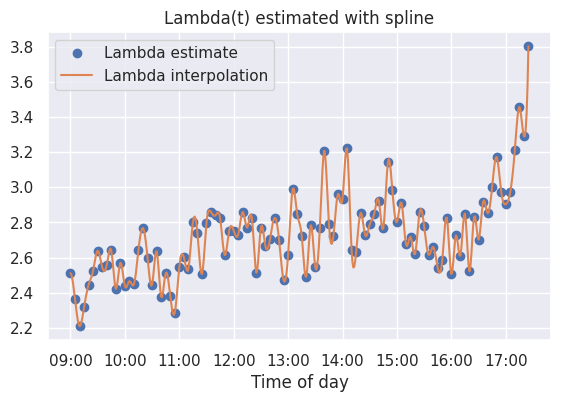

In [93]:
x_time = pd.date_range("2023-01-01 09:00:00","2023-01-01 17:25:00",freq = '5min')
y = lambda_t.values
lambda_t_spline = CubicSpline(x_time,y, extrapolate = False)

x_time_spline = pd.date_range("2023-01-01 09:00:00","2023-01-01 17:29:00",freq = '1min')
fig, ax = plt.subplots(figsize=(6.5, 4))

ax.plot(x_time, y, 'o', label='Lmabda observed')
ax.plot(x_time_spline, lambda_t_spline(x_time_spline), label="Lambda spline")
xfmt = md.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)
plt.title('Lambda(t) estimated with spline')
plt.xlabel("Time of day")
plt.legend(['Lambda estimate', "Lambda interpolation"])

plt.show()

Or with a better smoothing:

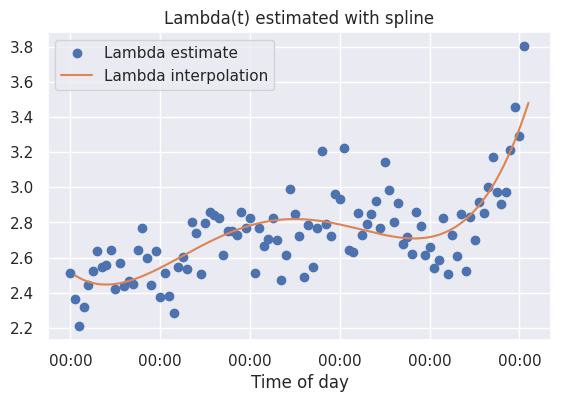

In [69]:
x_time = pd.date_range("2023-01-01 09:00:00","2023-01-01 17:25:00",freq = '5min')
y = lambda_t.values
lambda_t_spline_1 = UnivariateSpline(list(range(len(x_time))),y, k = 4)

x = np.linspace(1, len(x_time), num = 500)
fig, ax = plt.subplots(figsize=(6.5, 4))

ax.plot(list(range(len(x_time))), y, 'o', label='Lmabda observed')
ax.plot(x, lambda_t_spline_1(x), label="Lambda spline")
xfmt = md.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)
plt.title('Lambda(t) estimated with spline')
plt.xlabel("Time of day")
plt.legend(['Lambda estimate', "Lambda interpolation"])

plt.show()

We see that the intensity is higher at the end of the day, which means more trades. Also one can recognize the opening of the US market around 14:00-15:00 that start to bring informations on the European one and causes some trades.

In [105]:
trade_durations = pd.concat([(df['ts'].diff().dropna() / pd.Timedelta(minutes=1)) for df in data_dict.values()])

/usr/local/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


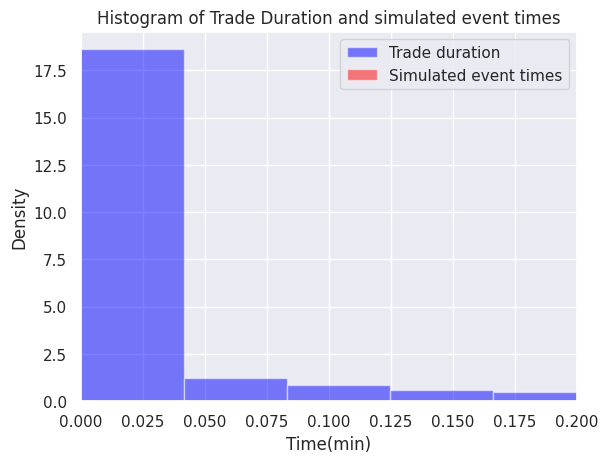

In [106]:

plt.hist(trade_durations, bins=200, density=True, alpha=0.5, color='blue')
plt.hist(event_times, bins=200, density=True, alpha=0.5, color='red')
plt.legend(["Trade duration",'Simulated event times'])
plt.xlabel('Time(min)')
plt.ylabel('Density')
plt.xlim((0,0.2))
plt.title('Histogram of Trade Duration and simulated event times')
plt.show()